In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

# Remove grid in all the figures
plt.rcParams['axes.grid'] = False

In [6]:
# Parameters

model_height = 1000
model_width = 1000
minimum_thickness = 1
maximum_thickness = 15
SANDSTONE = 0
SILT = 1
SHALE = 2

# Now call the generate_facies_statistics function with these parameters
N = 1000  # Or however many realizations you need

In [7]:
def randomLayerModel(model_height, model_width, minimum_thickness, maximum_thickness):
    facies_model = np.zeros((model_height, model_width))
    model_free_space = model_height

    while model_free_space > 0:
        random_thickness = np.random.randint(minimum_thickness, maximum_thickness + 1)
        random_facies = np.random.randint(0, 3)
        layer_top = max(model_free_space - random_thickness, 0)
        facies_model[layer_top:model_free_space, :] = random_facies
        model_free_space -= random_thickness

    return facies_model

In [12]:
facies_model = randomLayerModel(model_height, model_width, minimum_thickness, maximum_thickness)

In [13]:
# Assuming facies_model and facies_cmap are already defined in your notebook
midModel = int(model_height/2)
strata_column = facies_model[:, midModel]

# Get the unique states from facies_model
unique_states = np.unique(facies_model)

# Convert strata_column to one-hot encoding format
strata = np.zeros((len(strata_column), len(unique_states)))

for i, state in enumerate(unique_states):
    strata[:, i] = (strata_column == state).astype(int)

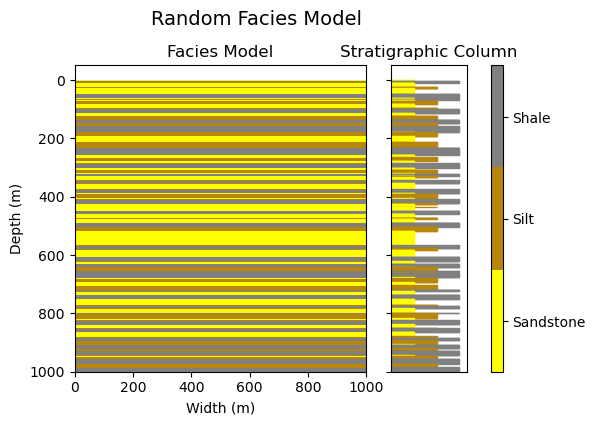

In [14]:
# Define the colors for each state (Assuming three states as before)
facies_colors = ['yellow', 'darkgoldenrod', 'grey']

# Define lengths for each state (e.g. 0.3 for state 0, 0.6 for state 1, 0.9 for state 2)
lengths = [0.3, 0.6, 0.9]

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4), gridspec_kw={'width_ratios': [5, 1]})
facies_cmap = plt.cm.colors.ListedColormap(facies_colors)
im = ax1.imshow(facies_model, cmap=facies_cmap, extent=[0, model_width, model_height, 0], aspect='equal')
ax1.set_title('Facies Model')
ax1.set_xlabel('Width (m)')
ax1.set_ylabel('Depth (m)')

# Plotting strata_column on ax2
for i in range(len(strata_column)):
    state = np.argmax(strata[i])
    ax2.fill_between([0, lengths[state]], i-0.5, i+0.5, color=facies_colors[state])
ax2.set_title('Stratigraphic Column')
ax2.set_xlim(0, 1)
#ax2.set_xlabel('Horizontal Extent')
ax2.set_xticks([])

# Remove y-axis ticks and labels from ax2 for cleaner visuals
# ax2.set_yticklabels([])
# ax2.set_yticks([])

# Add a colorbar to the right of the plot, referencing the facies_cmap

cbar = fig.colorbar(im, ax=ax2, pad=0.2, aspect=25, ticks=[0.33, 1, 1.66],)
cbar.ax.set_yticklabels(['Sandstone', 'Silt', 'Shale'])
#cbar.set_label('Facies', loc='', labelpad=1)

plt.tight_layout()
# Remove the gap between the two plots
plt.subplots_adjust(wspace=-0.35)

plt.suptitle('Random Facies Model', y=1.05, fontsize=14)

plt.show()

---

In [15]:
def modelDeformation(model):
    amplitude = np.random.randint(-model_height, model_height)
    xo = np.random.randint(0, model_height)
    sigma_x = np.random.randint(100, model_height)
    sigma_y = np.random.randint(int(model_height/2), model_height)

    """Deform the given model with a 2D Gaussian displacement."""
    
    def gaussian2D(x, y, amplitude, xo, yo, sigma_x, sigma_y):
        """2D Gaussian function."""
        return amplitude * np.exp(-((x-xo)**2/(2*sigma_x**2) + (y-yo)**2/(2*sigma_y**2)))
    
    # Create the coordinate grid
    x = np.arange(model.shape[1])
    y = np.arange(model.shape[0])
    x, y = np.meshgrid(x, y)
    
    # Gaussian deformation centered at (xo, yo)
    yo = model.shape[0] // 2
    gaussian2D_array = gaussian2D(x, y, amplitude, xo, yo, sigma_x, sigma_y)
    
    # Create displacement fields
    dx = gaussian2D_array
    dy = gaussian2D_array
    
    # Apply deformation using interpolation
    coords = np.array([y+dy, x+dx])
    deformed_model = map_coordinates(model, coords, order=1, mode='reflect')
    
    return deformed_model

In [16]:
deformed_model = modelDeformation(facies_model)

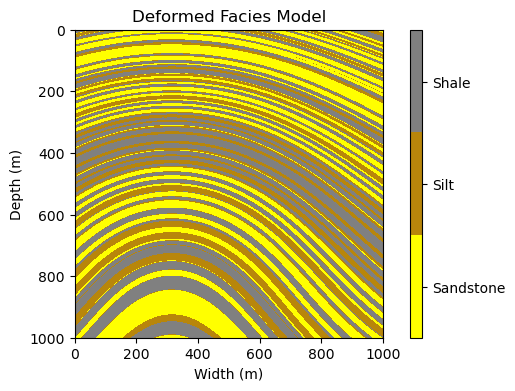

In [17]:
# Plot the deformed model
plt.figure(figsize=(7, 4))
plt.imshow(deformed_model, cmap=facies_cmap, extent=[0, model_width, model_height, 0], aspect='equal')
plt.title('Deformed Facies Model')
plt.xlabel('Width (m)')
plt.ylabel('Depth (m)')
# Add a colorbar to the right of the plot, referencing the facies_cmap
cbar = plt.colorbar(pad=0.05, aspect=25, ticks=[0.33, 1, 1.66],)
cbar.ax.set_yticklabels(['Sandstone', 'Silt', 'Shale'])

plt.show()

In [38]:
def modelTilt(model):
    e = np.random.uniform(0.0, 0.5)    # Intercept of the plane
    f = np.random.uniform(0.0, 1.0)   # Slope of the plane in x direction
    g = np.random.uniform(-0.1, 0.1)  # Slope of the plane in y direction

    y, x = np.mgrid[:model.shape[0], :model.shape[1]]
    z = e + f*x + g*y

    # Apply deformation using interpolation
    coords = np.array([y + z, x])
    modelTilted = map_coordinates(model, coords, order=1, mode='reflect') # 'grid-wrap' The input is extended by wrapping around to the opposite edge.

    return modelTilted

In [39]:
modelTilted = modelTilt(deformed_model)

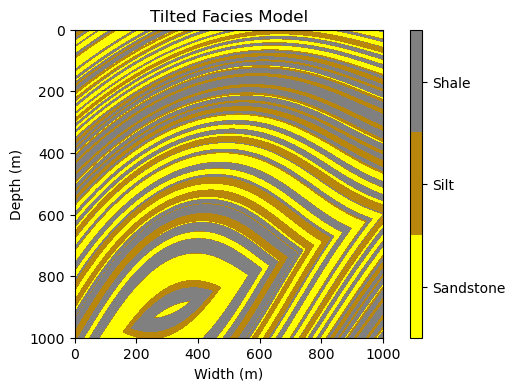

In [40]:
# Plot the deformed model
plt.figure(figsize=(7, 4))
plt.imshow(modelTilted, cmap=facies_cmap, extent=[0, model_width, model_height, 0], aspect='equal')
plt.title('Tilted Facies Model')
plt.xlabel('Width (m)')
plt.ylabel('Depth (m)')
# Add a colorbar to the right of the plot, referencing the facies_cmap
cbar = plt.colorbar(pad=0.05, aspect=25, ticks=[0.33, 1, 1.66],)
cbar.ax.set_yticklabels(['Sandstone', 'Silt', 'Shale'])

plt.show()

In [ ]:
def modelFault(model, direction='up', random_horizontal_invert=False):
    fault_displacement = np.random.randint(-(model_height*0.2), (model_height*0.2))  # Or some random value

    modelFaulted = model.copy()
    # Get the upper triangle indices
    triu_indices = np.triu_indices(model.shape[0])

    # Ensure direction input is valid
    if direction not in ['up', 'down']:
        raise ValueError("direction must be either 'up' or 'down'")

    # Determine the shift direction (positive or negative)
    fault_displacement = fault_displacement if direction == 'up' else -fault_displacement
    
    # Shifting
    shifted = sp.ndimage.shift(
        model, 
        (fault_displacement, 0), 
        cval=model[0, 0] * 0.9)

    # Applying the shifted upper triangle back to the original matrix
    modelFaulted[triu_indices] = shifted[triu_indices]

    # Conditionally inverting the matrix horizontally
    if random_horizontal_invert and np.random.rand() < 0.5:  # 50% chance to flip
        modelFaulted = np.fliplr(modelFaulted)

    return modelFaulted

In [42]:
# Assuming model2D_impedance is predefined
modelFaulted = modelFault(modelTilted, direction='up', random_horizontal_invert=True)

In [ ]:
# Plot the deformed model
plt.figure(figsize=(7, 4))
plt.imshow(modelFaulted, cmap=facies_cmap, extent=[0, model_width, model_height, 0], aspect='equal')
plt.title('Faulted Facies Model')
plt.xlabel('Width (m)')
plt.ylabel('Depth (m)')
# Add a colorbar to the right of the plot, referencing the facies_cmap
cbar = plt.colorbar(pad=0.05, aspect=25, ticks=[0.33, 1, 1.66],)
cbar.ax.set_yticklabels(['Sandstone', 'Silt', 'Shale'])

plt.show()

In [ ]:
def planarUnconformity(model):

    planar_unconformity_depth = (np.random.randint(1, modelFaulted.shape[0]/2))

    # Keep the matrix, from the planar_unconformity_depth till the end of the model
    modelUnconformity = model.copy()

    #  Keep the values from the planar_unconformity_depth till the end of the model, and the rest equal to 0
    modelUnconformity[:planar_unconformity_depth, :] = 0

    # Make a new array from 0 till the planar_unconformity_depth
    new_model = np.zeros((planar_unconformity_depth, model.shape[1]))
    
    # Select a random integer number between 0 and 100, corresponding to the thickness of the layer
    random_thickness = np.random.randint(minimum_thickness, maximum_thickness)

    # Select randomly between sandstone, shale and limestone
    random_facies = np.random.randint(0, 3)

    # Add the layer to the bottom of the new_model
    new_model[-random_thickness:, :] = random_facies

    # Check the free space in the new_model after adding the layer
    model_free_space = planar_unconformity_depth - random_thickness

    # Check if the free space is less than 0, select a new random thickness and a random facies, and add it to the model. If not, get out of the loop
    while model_free_space > 0:
        # Select a random integer number between minimum_thickness and maximum_thickness, corresponding to the thickness of the layer
        random_thickness = np.random.randint(minimum_thickness, maximum_thickness)
        random_facies = np.random.randint(0, 3)

        new_model[-random_thickness-model_free_space:-random_thickness, :] = random_facies

        # Check the free space in the model
        model_free_space = model_free_space - random_thickness

    # Replace from the planar_unconformity_depth to the top of the modelUnconformity with the new_model
    modelUnconformity[:planar_unconformity_depth, :] = new_model
    
    
    return modelUnconformity

In [ ]:
erodedModel = planarUnconformity(modelFaulted)

In [ ]:
# Plot the deformed model
plt.figure(figsize=(7, 4))
plt.imshow(erodedModel, cmap=facies_cmap, extent=[0, model_width, model_height, 0], aspect='equal')
plt.title('Unconformity Facies Model')
plt.xlabel('Width (m)')
plt.ylabel('Depth (m)')
# Add a colorbar to the right of the plot, referencing the facies_cmap
cbar = plt.colorbar(pad=0.05, aspect=25, ticks=[0.33, 1, 1.66],)
cbar.ax.set_yticklabels(['Sandstone', 'Silt', 'Shale'])

plt.show()

In [ ]:
# Figure Summary
fix, ax = plt.subplots(1, 5, figsize=(15, 4), sharey = True)
ax[0].imshow(facies_model, cmap=facies_cmap, extent=[0, model_width, model_height, 0], aspect='equal')
ax[0].set_title('Facies Model')
ax[0].set_xlabel('Width (m)')
ax[0].set_ylabel('Depth (m)')
ax[0].invert_yaxis()
facies_cmap = plt.cm.colors.ListedColormap(['yellow', 'darkgoldenrod', 'grey'])
# # Plot the facies model
#ax[0].imshow(model.layerModel()[0], cmap = facies_cmap, extent = [0, model_width, 0, model_height])
# Add horizontal colorbar at the bottom of the plot
cbar = plt.colorbar(ax[0].imshow(facies_model, cmap = facies_cmap, extent = [0, model_width, model_height, 0]), ax=ax[0], ticks=[0.33, 1, 1.66], orientation='horizontal')#
cbar.set_label((15*' ').join(['Facies']), fontsize=14)
cbar.set_ticklabels(['Sandstone', 'Silt', 'Shale'])

ax[1].imshow(deformed_model, cmap=facies_cmap, extent=[0, model_width, model_height, 0], aspect='equal')
ax[1].set_title('Deformed Facies Model')
ax[1].set_xlabel('Width (m)')
cbar = plt.colorbar(ax[1].imshow(deformed_model, cmap = facies_cmap, extent = [0, model_width, model_height, 0]), ax=ax[1], ticks=[0.33, 1, 1.66], orientation='horizontal')#
cbar.set_label((15*' ').join(['Facies']), fontsize=14)
cbar.set_ticklabels(['Sandstone', 'Silt', 'Shale'])

ax[2].imshow(modelTilted, cmap=facies_cmap, extent=[0, model_width, model_height, 0], aspect='equal')
ax[2].set_title('Tilted Facies Model')
ax[2].set_xlabel('Width (m)')
cbar = plt.colorbar(ax[2].imshow(modelTilted, cmap = facies_cmap, extent = [0, model_width, model_height, 0]), ax=ax[2], ticks=[0.33, 1, 1.66], orientation='horizontal')#
cbar.set_label((15*' ').join(['Facies']), fontsize=14)
cbar.set_ticklabels(['Sandstone', 'Silt', 'Shale'])

ax[3].imshow(modelFaulted, cmap=facies_cmap, extent=[0, model_width, model_height, 0], aspect='equal')
ax[3].set_title('Faulted Facies Model')
ax[3].set_xlabel('Width (m)')
cbar = plt.colorbar(ax[3].imshow(modelFaulted, cmap = facies_cmap, extent = [0, model_width, model_height, 0]), ax=ax[3], ticks=[0.33, 1, 1.66], orientation='horizontal')#
cbar.set_label((15*' ').join(['Facies']), fontsize=14)
cbar.set_ticklabels(['Sandstone', 'Silt', 'Shale'])

ax[4].imshow(erodedModel, cmap=facies_cmap, extent=[0, model_width, model_height, 0], aspect='equal')
ax[4].set_title('Unconformity Facies Model')
ax[4].set_xlabel('Width (m)')
cbar = plt.colorbar(ax[4].imshow(erodedModel, cmap = facies_cmap, extent = [0, model_width, model_height, 0]), ax=ax[4], ticks=[0.33, 1, 1.66], orientation='horizontal')#
cbar.set_label((15*' ').join(['Facies']), fontsize=14)
cbar.set_ticklabels(['Sandstone', 'Silt', 'Shale'])
    
plt.tight_layout()

plt.show()

### Markov Chain

In [ ]:
# Define Markov Chain transition matrix
# Rows:    [Deformation, Tilt, Fault, Unconformity]
# Columns: [Deformation, Tilt, Fault, Unconformity]

initial_probabilities = np.array([0.30, 0.25, 0.30, 0.15])

transition_matrix = np.array([
    [0.20, 0.25, 0.30, 0.25],  # Deformation
    [0.25, 0.20, 0.30, 0.25],  # Tilt
    [0.25, 0.30, 0.20, 0.25],  # Fault
    [0.25, 0.30, 0.25, 0.20]   # Unconformity
])


In [ ]:
def markovChain_geologicalProcessesModeling(model, N=5):
    operations = [modelDeformation, modelTilt, modelFault, planarUnconformity]
    
    for _ in range(N):
        # Determine the next operation based on current state
        if _ == 0:
            # Select the initial transformation
            chosen_operation_idx = np.random.choice(4, p=initial_probabilities)
        else:
            # Use the transition matrix to determine next operation
            chosen_operation_idx = np.random.choice(4, p=transition_matrix[chosen_operation_idx, :])

        chosen_operation = operations[chosen_operation_idx]
        model = chosen_operation(model)

    return model

In [ ]:
# Example Usage:
initial_model = randomLayerModel(model_height, model_width, minimum_thickness, maximum_thickness)
transformed_model = markovChain_geologicalProcessesModeling(initial_model)

In [ ]:
def generate_and_display_models(n=5):
    fig, axes = plt.subplots(1, n, figsize=(20, 6), sharey=True)

    # Show ticks to y-axis in 1st subplot
    axes[0].invert_yaxis()



    for i, ax in enumerate(axes):
        initial_model = randomLayerModel(model_height, model_width, minimum_thickness, maximum_thickness)
        transformed_model = markovChain_geologicalProcessesModeling(initial_model)

        im = ax.imshow(transformed_model, cmap=facies_cmap)  # Use appropriate colormap

        ax.set_title(f'Realization {i+1}')
        ax.set_xlabel('Width (m)')
        # if i == 0:  # Add y-label only to the first subplot for clarity
        ax.set_ylabel('Depth (m)')
        # else:
        # ax.set_yticks([])  # Hide y-ticks
        
        # Add a horizontal colorbar at the bottom of each subplot with reduced spacing
        cbar = plt.colorbar(im, ax=ax, ticks=[0.33, 1, 1.66], orientation='horizontal', pad=0.1)
        #cbar.set_label((15*' ').join(['Facies']), fontsize=14)
        cbar.set_ticklabels(['Sandstone', 'Silt', 'Shale'])

    plt.suptitle('Random Facies Models', y=0.9, fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Call the function to generate and display models
generate_and_display_models(5)

---